In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import warnings
from tqdm import tqdm

In [2]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    rets.iloc[0] = 0
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD, maxDDD

# Generate sample

In [3]:
np.random.seed(12345)

In [4]:
# set parameters
arparams = np.array([0.75, -0.25])
maparams = np.array([0.65, 0.35])

In [5]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]
nobs = 250
y = arma_generate_sample(arparams, maparams, nobs)

In [6]:
dates = pd.date_range("1980-1-1", freq="M", periods=nobs)
y = pd.Series(y, index=dates)

<AxesSubplot:>

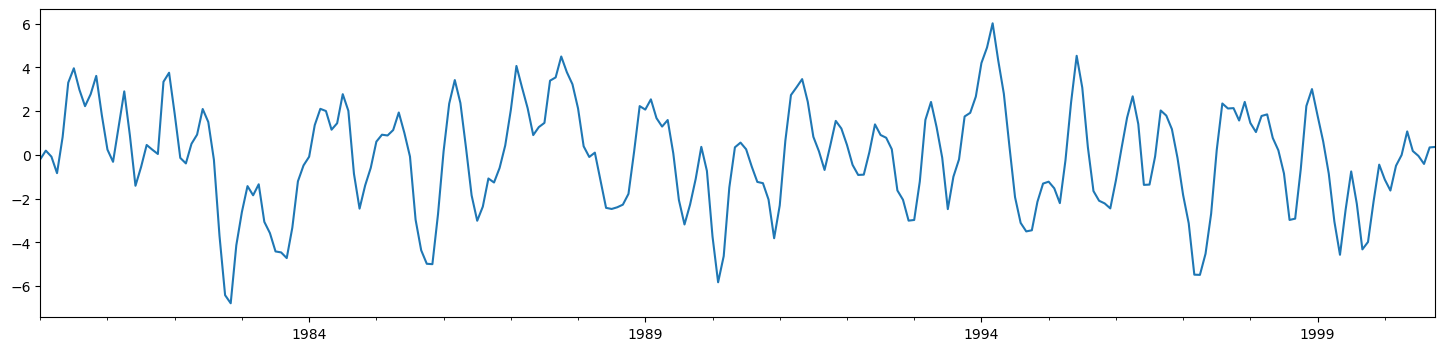

In [7]:
y.plot(figsize=(18,4))

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


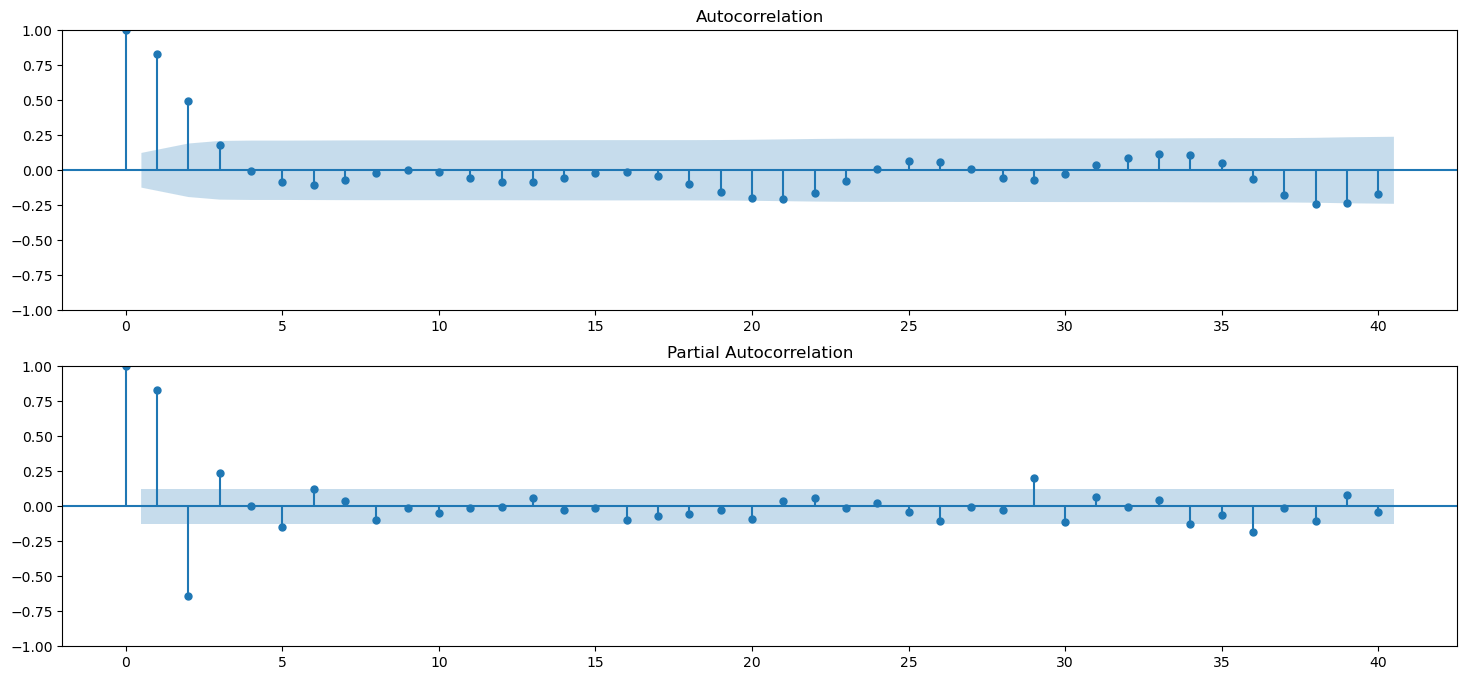

In [8]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y.values.squeeze(), lags=40, ax=ax2)

In [9]:
arma_mod = ARIMA(y, order=(2, 0, 2), trend="n")
arma_res = arma_mod.fit()
arma_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -353.445
Date:                Fri, 02 Jun 2023   AIC                            716.891
Time:                        07:07:19   BIC                            734.498
Sample:                    01-31-1980   HQIC                           723.977
                         - 10-31-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7905      0.142      5.566      0.000       0.512       1.069
ar.L2         -0.2314      0.124     -1.859      0.063      -0.475       0.013
ma.L1          0.7007      0.131      5.344      0.000       0.444       0.958
ma.L2          0.4061      0.097      4.177      0.000       0.216       0.597
sigma2         0.9801      0.093     10.514      0.000       0.797       1.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.96   Prob(JB):                         0.86
Heteroskedasticity (H):               0.92   Skew:                             0.02
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:>

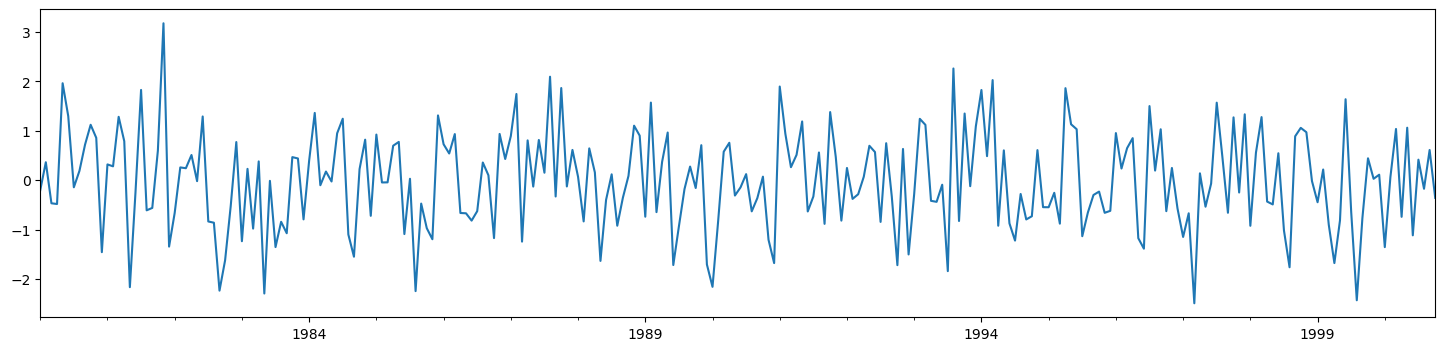

In [10]:
arma_res.resid.plot(figsize=(18,4))

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


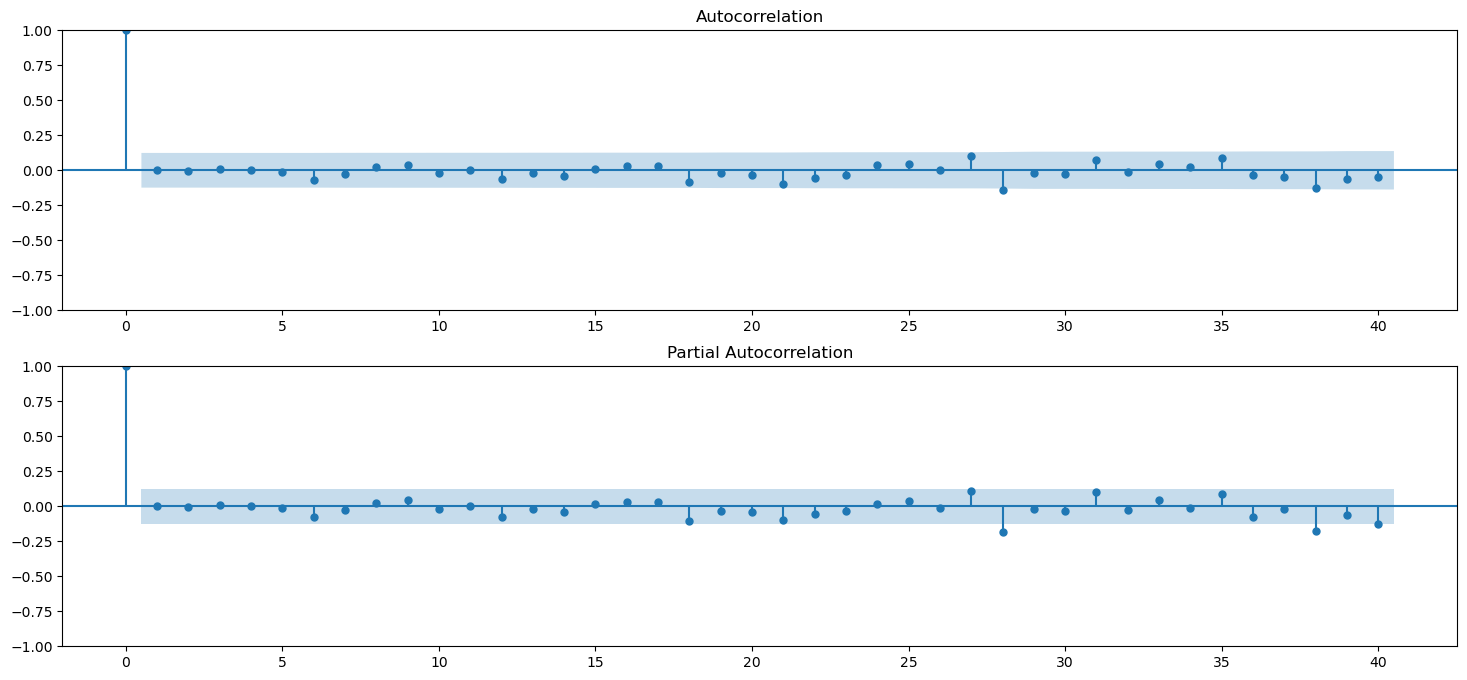

In [11]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arma_res.resid.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arma_res.resid.values, lags=40, ax=ax2)

In [12]:
sm.stats.durbin_watson(arma_res.resid.values)

1.9922669880602442

In [13]:
r,q,p = sm.tsa.acf(arma_res.resid.values, fft=True, qstat=True)

In [14]:
data = pd.DataFrame(index=np.arange(1,len(p)+1), columns=['AC', 'Q', 'pval'])
data.index.name = 'lag'
data['AC'] = r[1:]
data['Q'] = q
data['pval'] = p
data

,AC,Q,pval
lag,,,
1,0.002938,0.002184,0.962724
2,-0.003973,0.006195,0.996907
3,0.008729,0.025628,0.998917
4,-0.000064,0.025629,0.999919
5,-0.014565,0.080180,0.999906
6,-0.071915,1.415515,0.964908
7,-0.026387,1.596024,0.978798
8,0.021667,1.718240,0.988465
9,0.040882,2.155139,0.988770


In [15]:
data[data['pval']<0.01]

,AC,Q,pval
lag,,,


In [16]:
stats.normaltest(arma_res.resid.values)

NormaltestResult(statistic=0.1633461266979596, pvalue=0.921573205506832)

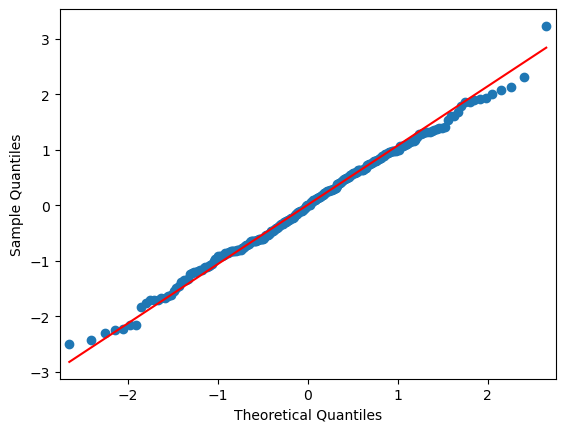

In [17]:
from statsmodels.graphics.api import qqplot

_ = qqplot(arma_res.resid.values, line="q", fit=True)

In [18]:
preds = arma_res.predict('1997-01-31', '2000-10-31')

In [19]:
# mean forecast error
(y['1997-01-31':] - preds).mean()

-0.13510926756580463

In [20]:
# mean squared error
((y['1997-01-31':] - preds)**2).mean()

1.0057203351803665

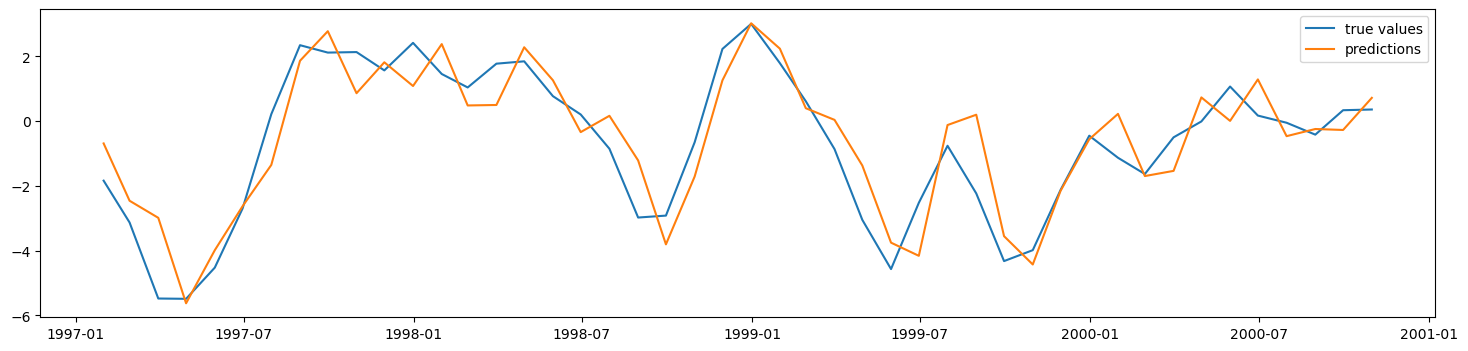

In [21]:
plt.figure(figsize=(18,4))
plt.plot(y['1997-01-31':], label='true values')
plt.plot(preds, label='predictions')
plt.legend()

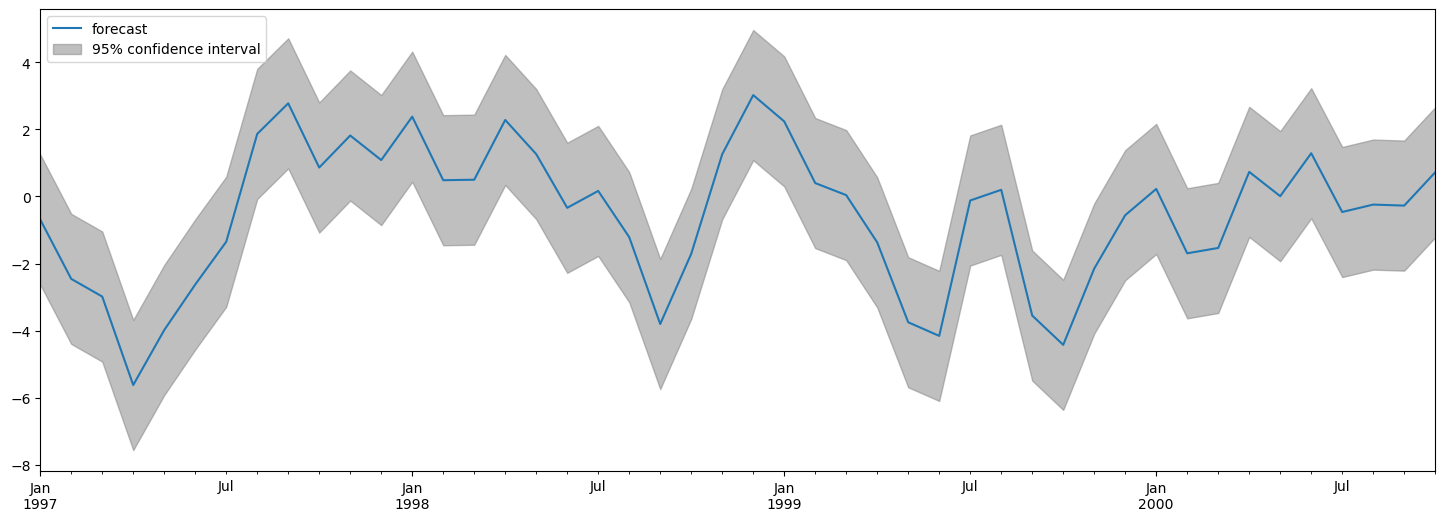

In [22]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = plot_predict(arma_res, start='1997-01-31', end='2000-10-31', ax=ax)
legend = ax.legend(loc="upper left")

In [23]:
import itertools

maxp = 5
maxq = 5

res_df = pd.DataFrame(columns=['ARIMA', 'BIC'])

for p,q in itertools.product(np.arange(0,maxp), np.arange(0,maxq)):
    # skip (0,0)
    if p==0 and q==0:
        continue
    
    mod = ARIMA(y, order=(p, 0, q), trend='n')
    res = mod.fit()
    
    if res.mle_retvals['converged']: # check that MLE converged
        res_df.loc[len(res_df.index)] = [f'({p},0,{q})', res.bic]

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alex/anaconda3/li

In [24]:
res_df.sort_values(by='BIC').head()

,ARIMA,BIC
6,"(1,0,2)",732.824726
11,"(2,0,2)",734.497856
7,"(1,0,3)",734.741918
3,"(0,0,4)",735.743715
14,"(3,0,0)",736.356314


# Applying to stocks

In [25]:
price = pd.read_csv('PRK.csv', index_col=0)

In [26]:
price = price['PRK']

In [27]:
price_train = price.loc[:'2022-12-31']
price_test = price.loc['2023-01-01':]
returns = price.pct_change()
returns_test = returns.loc['2023-01-01':]

In [28]:
price

Date
2013-01-02     43.241261
2013-01-03     43.000126
2013-01-04     43.325989
2013-01-07     42.889328
2013-01-08     43.123959
                 ...    
2023-05-05    105.709999
2023-05-08    102.410004
2023-05-09    102.070000
2023-05-10    102.400002
2023-05-11    101.190002
Name: PRK, Length: 2608, dtype: float64

<AxesSubplot:xlabel='Date'>

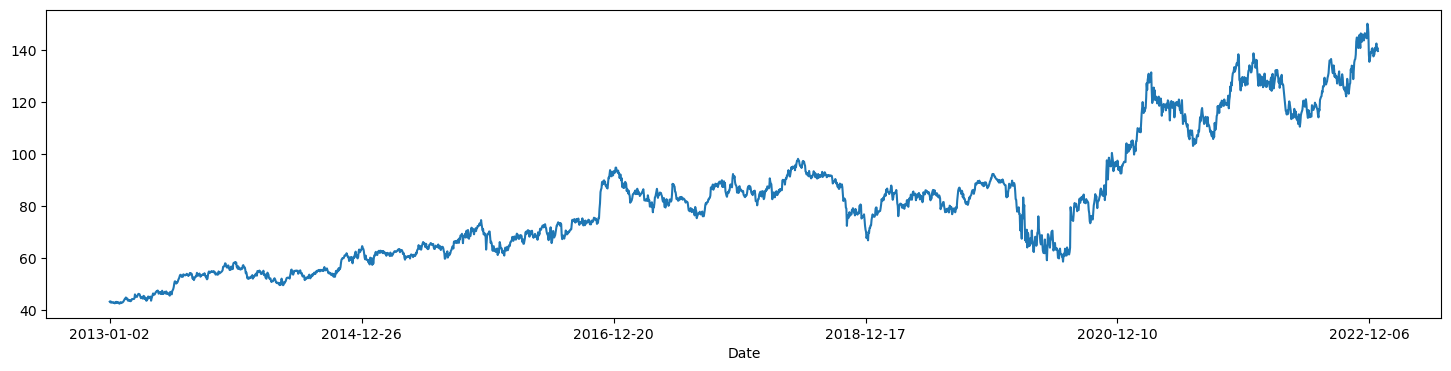

In [29]:
price_train.plot(figsize=(18,4))

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


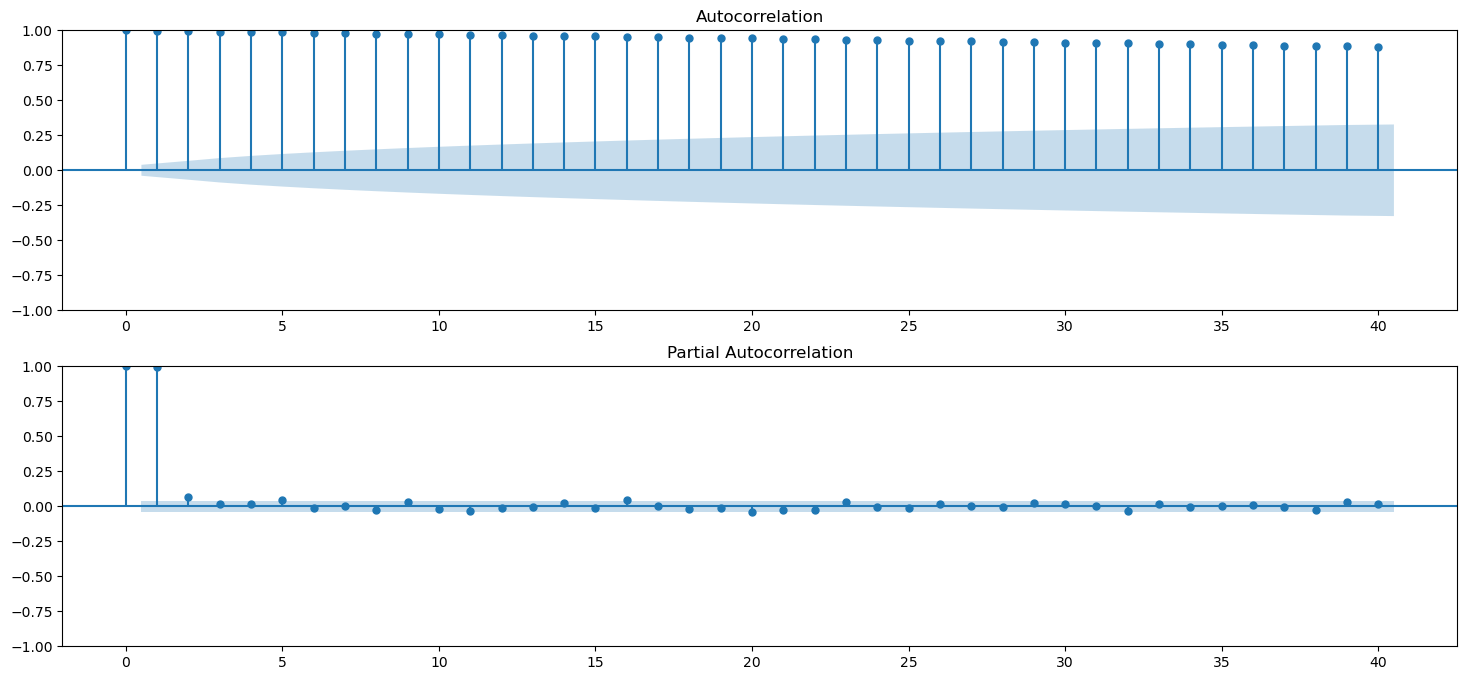

In [30]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(price_train.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(price_train.values, lags=40, ax=ax2)

<AxesSubplot:xlabel='Date'>

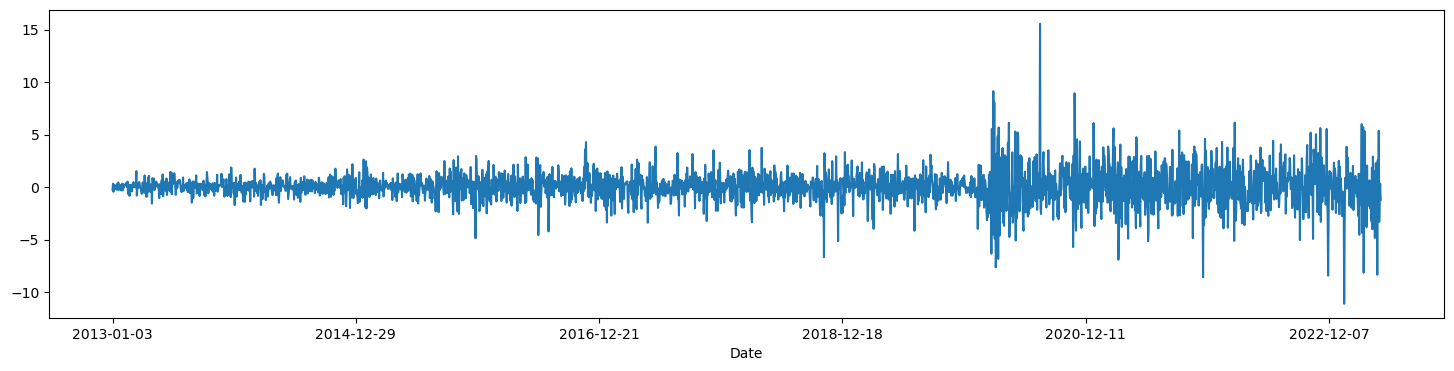

In [31]:
price.diff().iloc[1:].plot(figsize=(18,4))

In [32]:
price.diff().iloc[1:]

Date
2013-01-03   -0.241135
2013-01-04    0.325863
2013-01-07   -0.436661
2013-01-08    0.234631
2013-01-09   -0.143383
                ...   
2023-05-05    5.360001
2023-05-08   -3.299995
2023-05-09   -0.340004
2023-05-10    0.330002
2023-05-11   -1.209999
Name: PRK, Length: 2607, dtype: float64

In [33]:
# first year SD
price.diff().iloc[1:250].std()

0.5313382034426289

In [34]:
# last year SD
price.diff().iloc[-250:].std()

2.345763650186195

<AxesSubplot:xlabel='Date'>

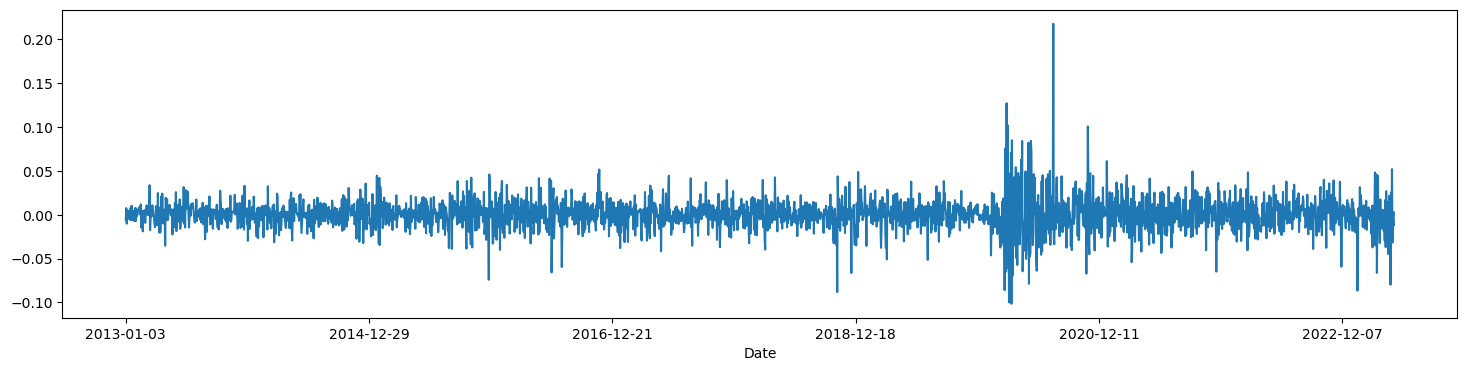

In [35]:
np.log(price).diff().iloc[1:].plot(figsize=(18,4))

In [36]:
# first year SD
np.log(price).diff().iloc[1:250].std()

0.010734800184503394

In [37]:
# last year SD
np.log(price).diff().iloc[-250:].std()

0.01891246361464943

In [38]:
dprice = np.log(price).diff().iloc[1:]
dprice_train = dprice.loc[price_train.index[1:]]
dprice_test = dprice.loc[price_test.index]

In [39]:
from statsmodels.tsa.stattools import adfuller

adfuller(dprice_train)

(-19.25499471685888,
 0.0,
 6,
 2510,
 {'1%': -3.4329579682301254,
  '5%': -2.8626921885291017,
  '10%': -2.5673833542324727},
 -12939.188660427286)

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


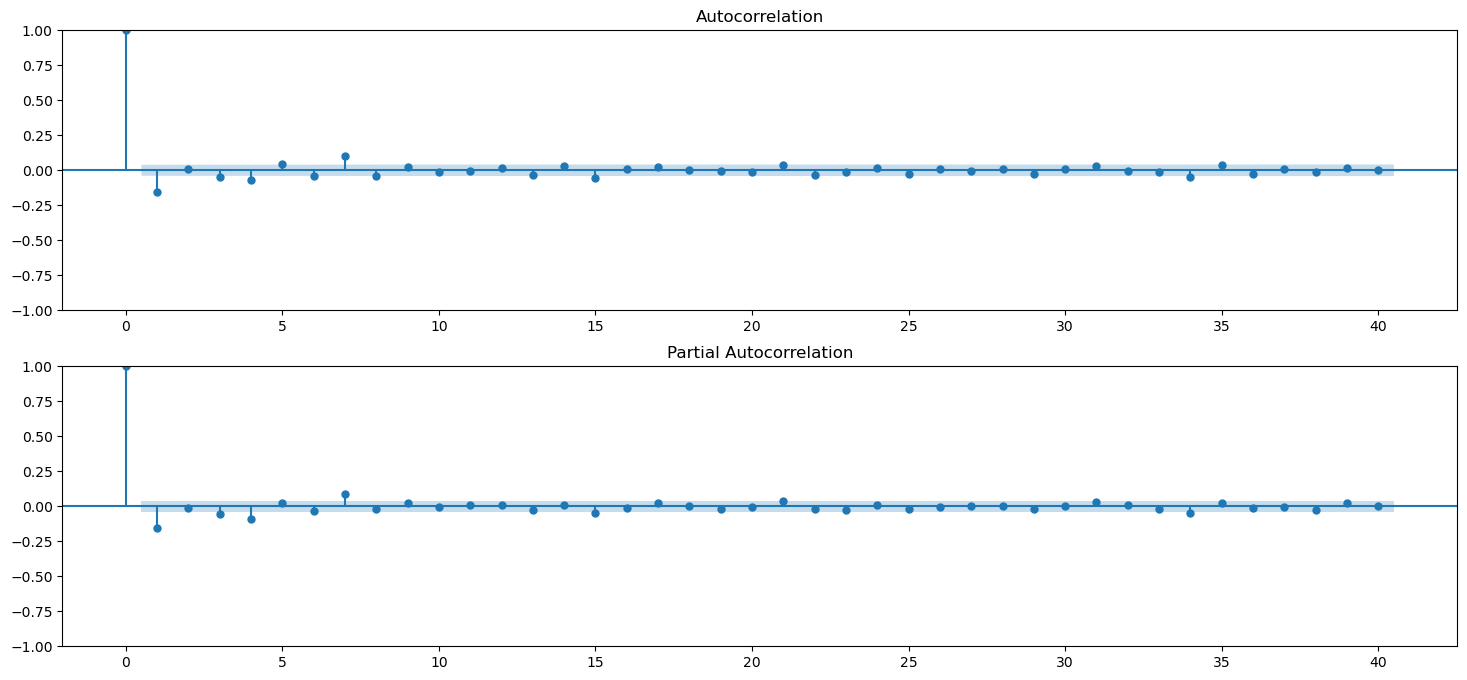

In [40]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dprice_train.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dprice_train.values, lags=40, ax=ax2)

In [41]:
r,q,p = sm.tsa.acf(dprice_train.values, fft=True, qstat=True)

In [42]:
data = pd.DataFrame(index=np.arange(1,len(p)+1), columns=['AC', 'Q', 'pval'])
data.index.name = 'lag'
data['AC'] = r[1:]
data['Q'] = q
data['pval'] = p

In [43]:
with pd.option_context('display.max_rows', 8):
    display(data)

,AC,Q,pval
lag,,,
1,-0.156059,61.373188,4.721972e-15
2,0.012050,61.739267,3.921828e-14
3,-0.051435,68.411475,9.340198e-15
4,-0.072866,81.807105,7.212134e-17
...,...,...,...
31,0.028218,154.898185,2.082987e-18
32,-0.003919,154.937380,4.656168e-18
33,-0.011451,155.272063,9.098285e-18
34,-0.045460,160.549200,2.425137e-18


In [44]:
maxp = 5
maxq = 5

res_df = pd.DataFrame(columns=['ARIMA', 'BIC'])

for p,q in tqdm(itertools.product(np.arange(maxp), np.arange(maxq))):
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        mod = ARIMA(dprice_train.values, order=(p, 0, q), trend='n')
        res = mod.fit()
        if res.mle_retvals['converged']:
            res_df.loc[len(res_df.index)] = [f'({p},0,{q})', res.bic]

25it [00:18,  1.34it/s]


In [45]:
res_df.sort_values(by='BIC').head()

,ARIMA,BIC
18,"(4,0,0)",-13061.840140
9,"(1,0,4)",-13059.246708
1,"(0,0,1)",-13058.767173
5,"(1,0,0)",-13057.602931
3,"(0,0,3)",-13056.479864


In [46]:
mod = ARIMA(dprice_train, order=(4, 0, 0), trend='n')
res = mod.fit()

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [47]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    PRK   No. Observations:                 2517
Model:                 ARIMA(4, 0, 0)   Log Likelihood                6550.497
Date:                Fri, 02 Jun 2023   AIC                         -13090.994
Time:                        07:07:48   BIC                         -13061.840
Sample:                             0   HQIC                        -13080.414
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1623      0.012    -13.640      0.000      -0.186      -0.139
ar.L2         -0.0217      0.013     -1.644      0.100      -0.048       0.004
ar.L3         -0.0661      0.014     -4.790      0.000      -0.093      -0.039
ar.L4         -0.0904      0.013     -6.968      0.000      -0.116      -0.065
sigma2         0.0003   3.57e-06     90.058      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             16762.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.17   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

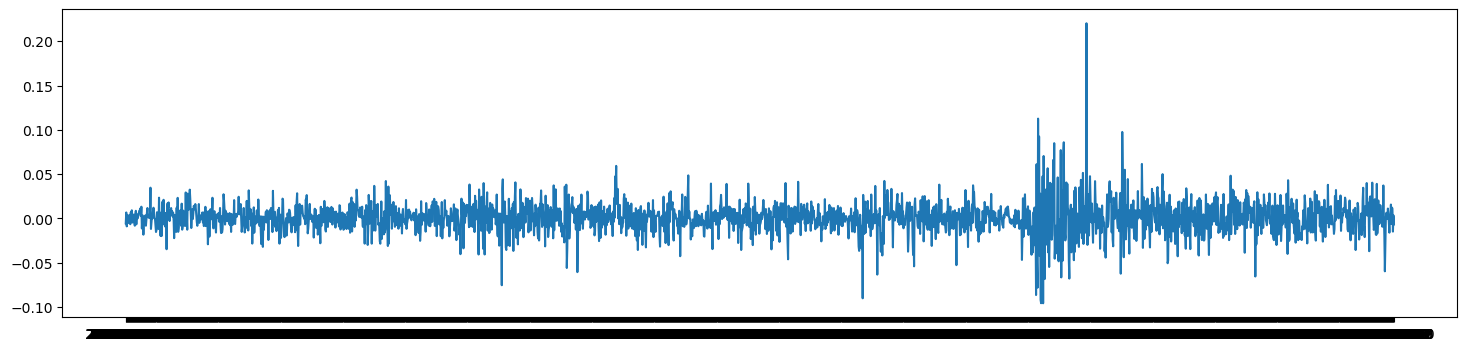

In [48]:
plt.figure(figsize=(18,4))
plt.plot(res.resid)

In [49]:
adfuller(res.resid)

(-17.375806563794253,
 5.106494307927957e-30,
 6,
 2510,
 {'1%': -3.4329579682301254,
  '5%': -2.8626921885291017,
  '10%': -2.5673833542324727},
 -12937.695421826485)

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


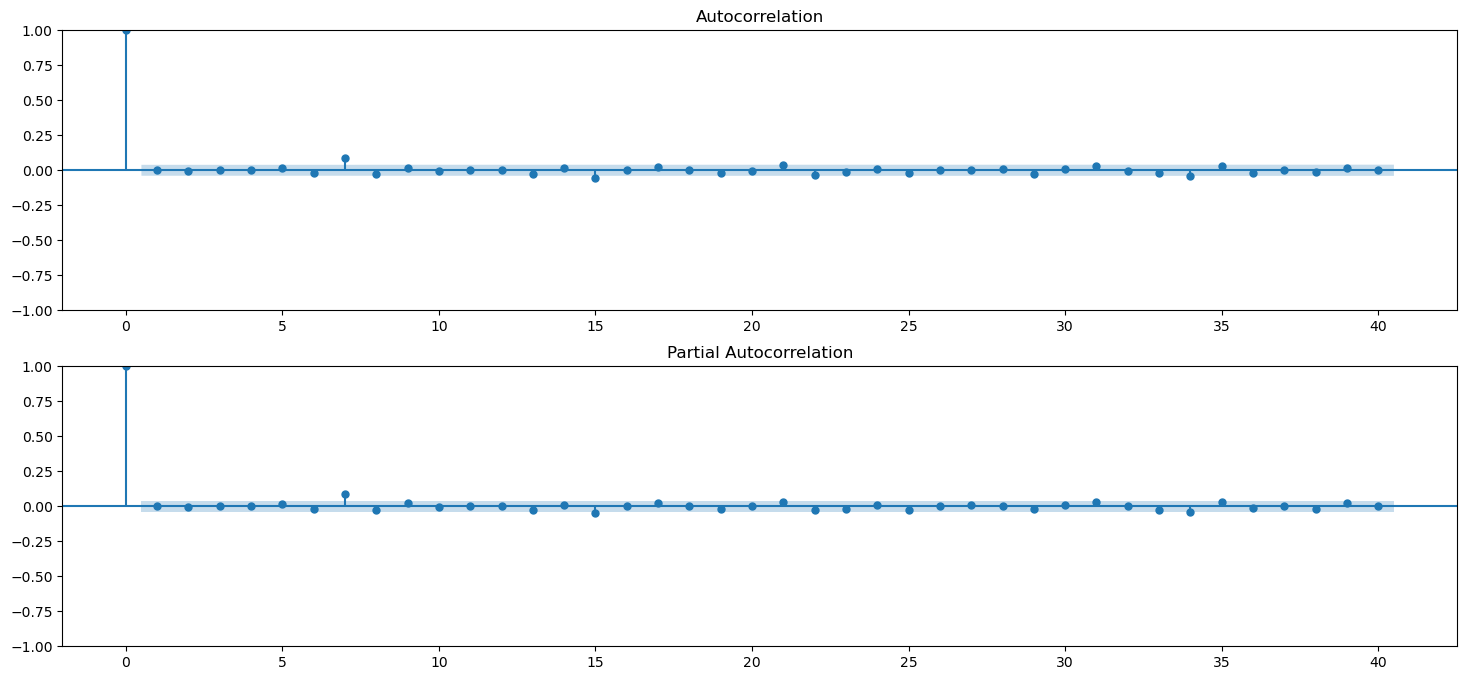

In [50]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res.resid, lags=40, ax=ax2)

In [51]:
stats.normaltest(res.resid)

NormaltestResult(statistic=645.7913857914285, pvalue=5.863843151015331e-141)

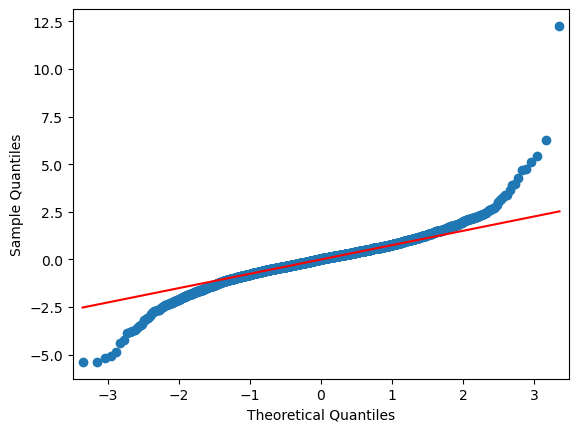

In [52]:
_ = qqplot(res.resid, line="q", fit=True)

In [53]:
r,q,p = sm.tsa.acf(res.resid, fft=True, qstat=True)

In [54]:
data = pd.DataFrame(index=np.arange(1,len(p)+1), columns=['AC', 'Q', 'pval'])
data.index.name = 'lag'
data['AC'] = r[1:]
data['Q'] = q
data['pval'] = p

In [55]:
with pd.option_context('display.max_rows', 8):
    display(data[data['pval']<0.01])

,AC,Q,pval
lag,,,
7,0.085616,20.724320,0.004200
8,-0.025897,22.419054,0.004196
9,0.019037,23.335189,0.005486
10,-0.007161,23.464861,0.009155
...,...,...,...
22,-0.033789,42.326013,0.005706
23,-0.014729,42.877498,0.007161
24,0.012471,43.273044,0.009257
25,-0.022181,44.524837,0.009468


In [56]:
preds = res.predict()

In [57]:
# mean forecast error
(dprice_train - preds).mean()

0.0006258151852940223

In [58]:
# mean squared error
((dprice_train - preds)**2).mean()

0.0003213744004164315

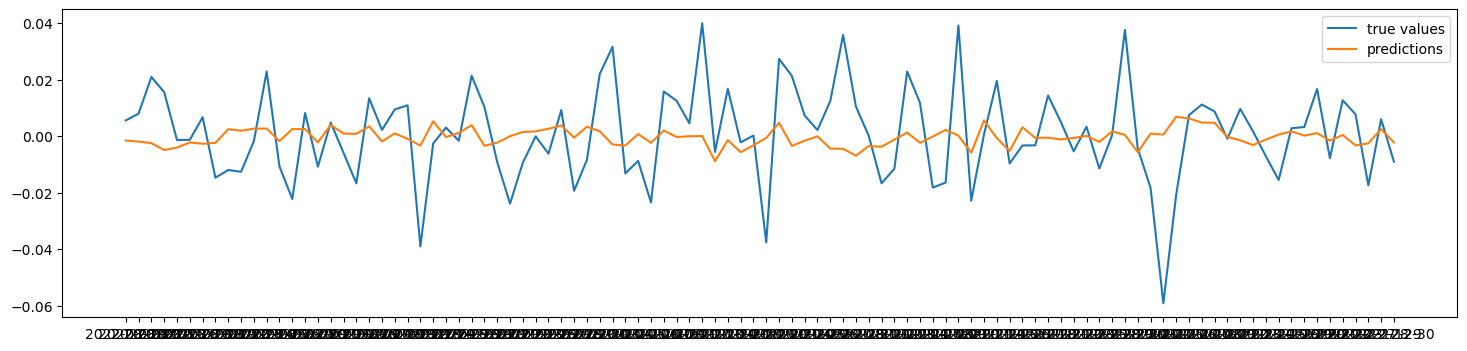

In [59]:
plt.figure(figsize=(18,4))
plt.plot(dprice_train[-100:], label='true values')
plt.plot(preds[-100:], label='predictions')
plt.legend()

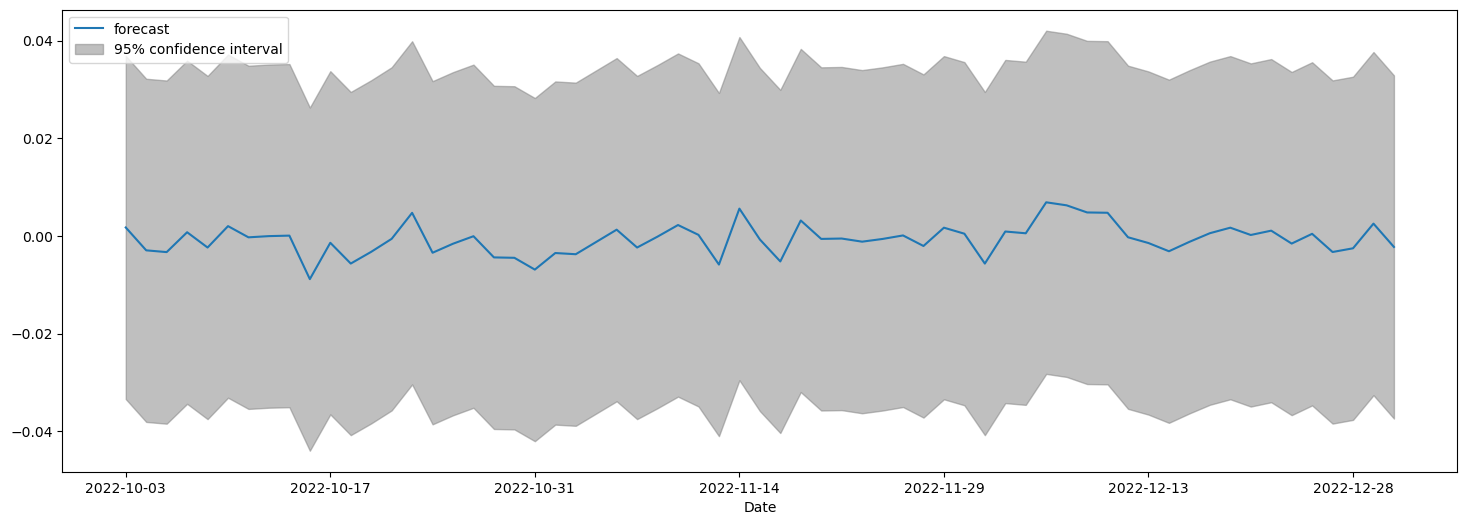

In [60]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = plot_predict(res, start='2022-10-03', end='2022-12-30', ax=ax)
legend = ax.legend(loc="upper left")

In [61]:
(np.sign(dprice_train) == np.sign(preds)).sum() / len(preds)

0.5486690504568932

In [62]:
main_mod = ARIMA(dprice_train, order=(4, 0, 0), trend='n')
main_res = main_mod.fit()

pred_df = pd.DataFrame(index=dprice_test.index, columns=['p'])

for t in tqdm(pred_df.index):
    # prepare data
    tmpdf = dprice.loc[:t].iloc[:-1]
    
    # create a model
    mod = main_mod.clone(tmpdf.values)
    with mod.fix_params(main_res.params):
        res = mod.fit()
    
    pred_df.loc[t] = res.predict(len(tmpdf)-1, len(tmpdf))[-1]

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
100%|██████████| 90/90 [00:10<00:00,  8.23it/s]


In [63]:
pred_df['dprice'] = dprice

In [64]:
pred_df

,p,dprice
Date,,
2023-01-03,0.001788,-0.010355
2023-01-04,0.003054,-0.001437
2023-01-05,0.000514,0.007235
2023-01-06,0.00036,0.017896
2023-01-09,-0.00203,-0.018396
...,...,...
2023-05-05,0.008716,0.052035
2023-05-08,-0.002296,-0.031715
2023-05-09,0.003587,-0.003326


In [65]:
(np.sign(pred_df['p']) == np.sign(pred_df['dprice'])).sum() / len(pred_df)

0.6333333333333333

In [66]:
positions = np.sign(pred_df['p'])

In [67]:
positions

Date
2023-01-03     1
2023-01-04     1
2023-01-05     1
2023-01-06     1
2023-01-09    -1
              ..
2023-05-05     1
2023-05-08    -1
2023-05-09     1
2023-05-10     1
2023-05-11    -1
Name: p, Length: 90, dtype: object

In [68]:
ret = positions * returns_test
cumret = (1 + ret).cumprod()

<AxesSubplot:xlabel='Date'>

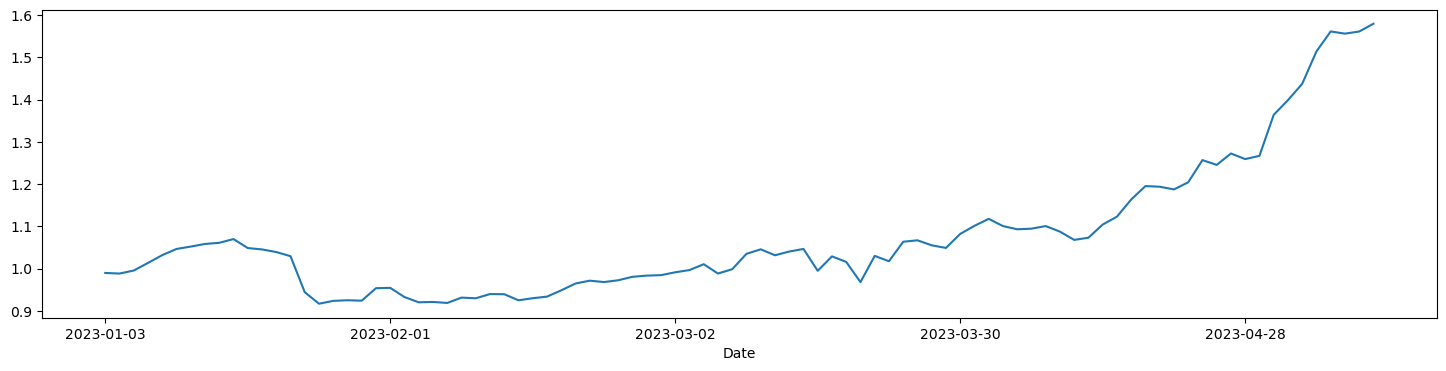

In [69]:
cumret.plot(figsize=(18,4))

<AxesSubplot:xlabel='Date'>

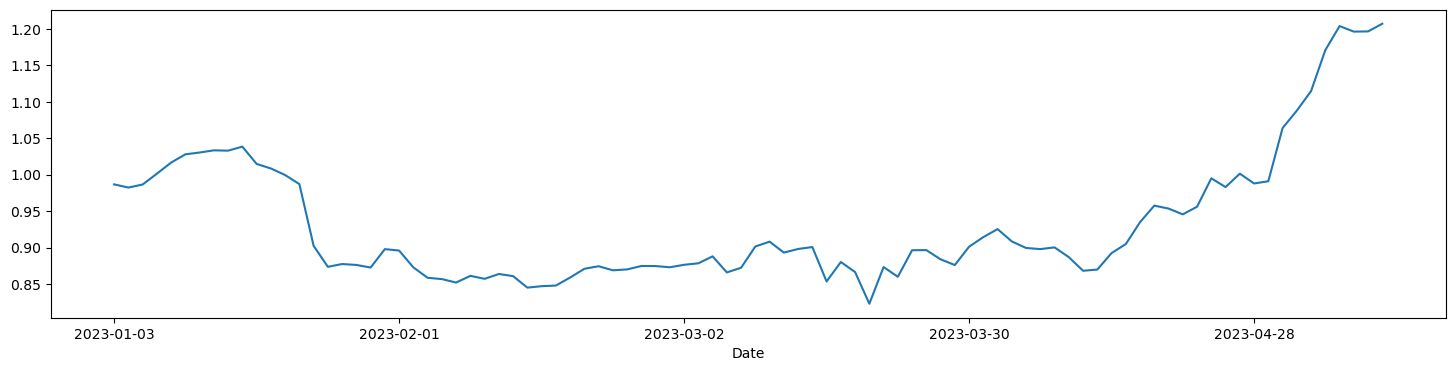

In [70]:
ret_tc = ret - 0.003
cumret_tc = (1 + ret_tc).cumprod()
cumret_tc.plot(figsize=(18,4))

In [71]:
results_df = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD', 'MaxDDD'])
results_df.loc['PRK'] = calculate_metrics(cumret)
results_df.loc['PRK with tc'] = calculate_metrics(cumret_tc)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
PRK,0.596359,2.704807,3.899958,-0.143101,50.0
PRK with tc,0.223433,0.758835,1.780202,-0.207575,72.0


# Try another stock

In [72]:
price = pd.read_csv('IVZ.csv', index_col=0)
price = price['IVZ']

In [73]:
price_train = price.loc[:'2022-12-31']
price_test = price.loc['2023-01-01':]
returns = price.pct_change()
returns_test = returns.loc['2023-01-01':]

<AxesSubplot:xlabel='Date'>

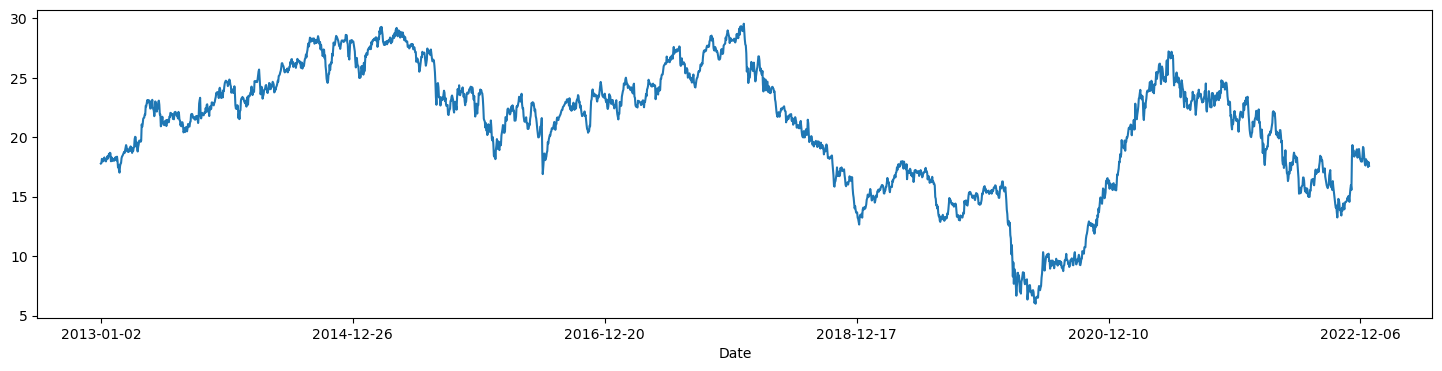

In [74]:
price_train.plot(figsize=(18,4))

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


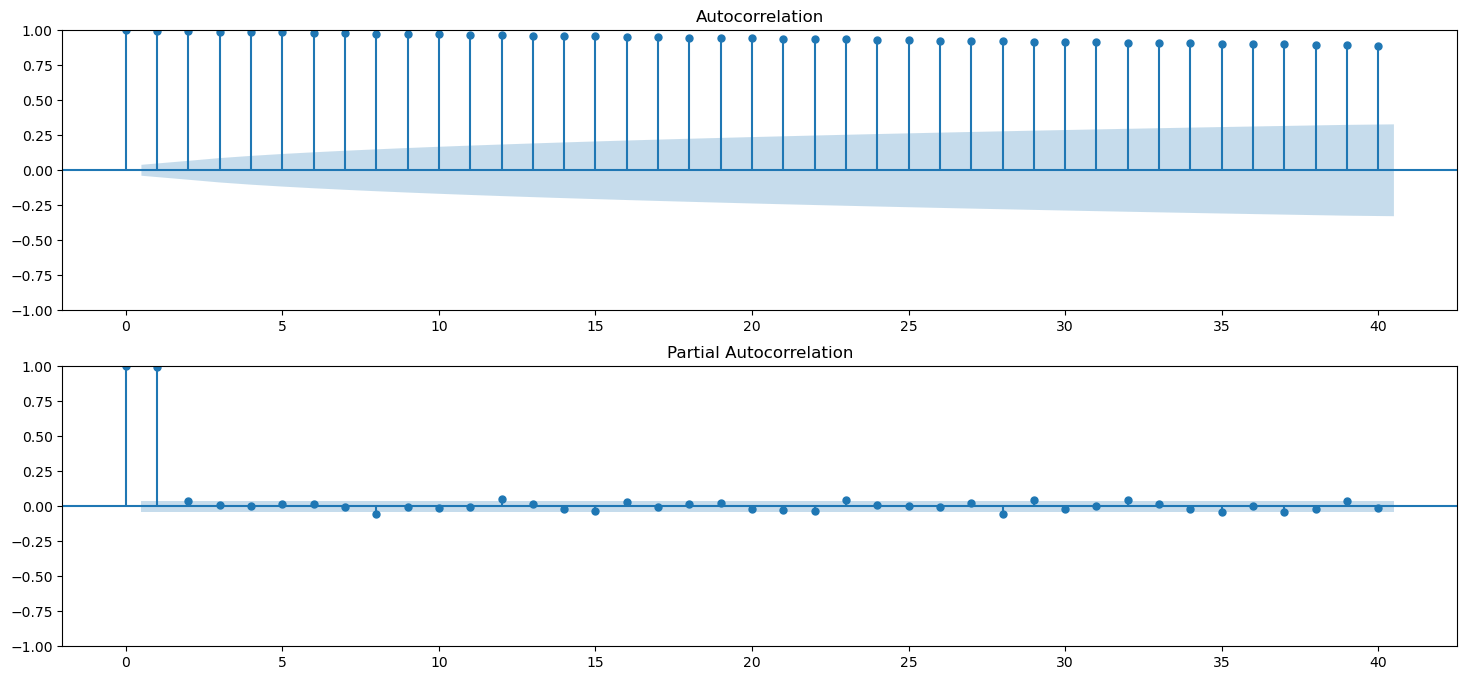

In [75]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(price_train.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(price_train.values, lags=40, ax=ax2)

In [76]:
dprice = np.log(price).diff().iloc[1:]
dprice_train = dprice.loc[price_train.index[1:]]
dprice_test = dprice.loc[price_test.index]

In [77]:
adfuller(dprice_train)

(-9.528233059250718,
 2.938186305281949e-16,
 27,
 2489,
 {'1%': -3.4329799947351503,
  '5%': -2.862701915447137,
  '10%': -2.5673885329713495},
 -11696.215069095439)

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


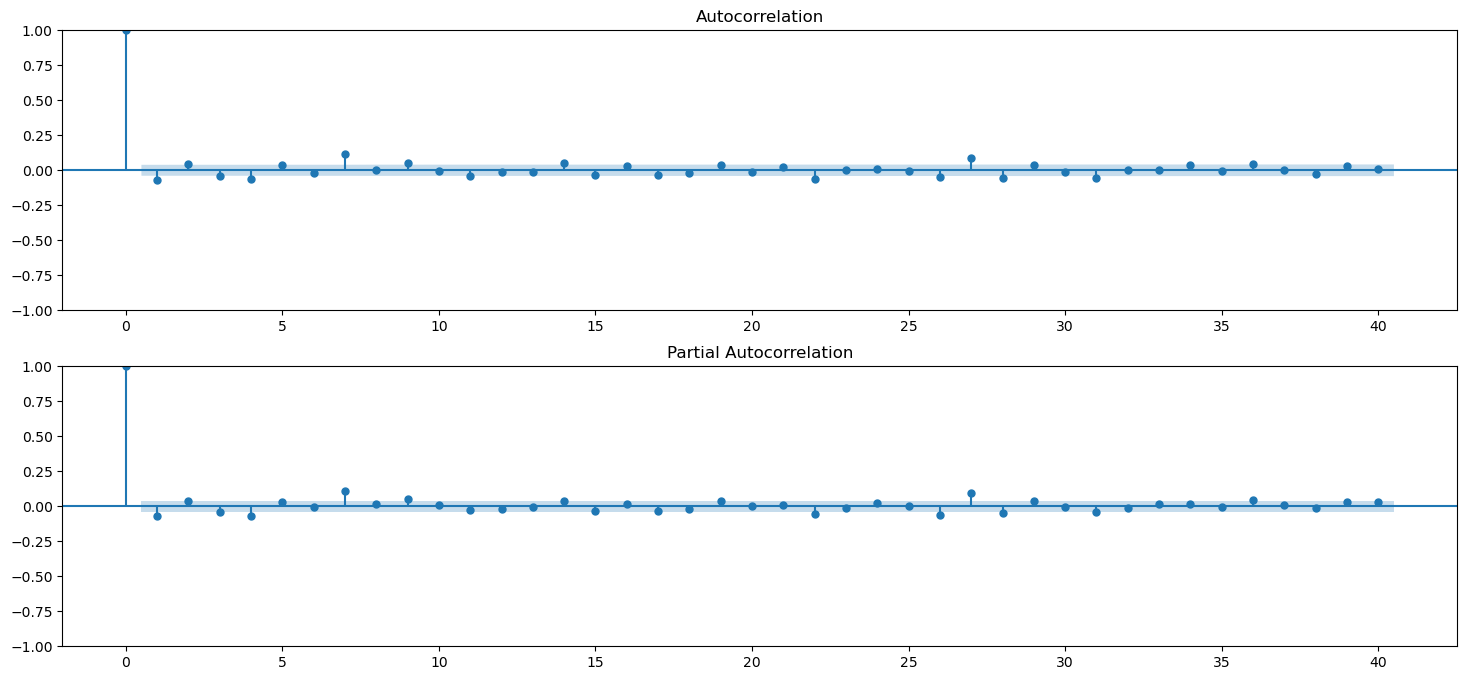

In [78]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dprice_train.values, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dprice_train.values, lags=40, ax=ax2)

In [79]:
r,q,p = sm.tsa.acf(dprice_train.values, fft=True, qstat=True)

In [80]:
data = pd.DataFrame(index=np.arange(1,len(p)+1), columns=['AC', 'Q', 'pval'])
data.index.name = 'lag'
data['AC'] = r[1:]
data['Q'] = q
data['pval'] = p
data

,AC,Q,pval
lag,,,
1,-0.072765,13.342882,2.594053e-04
2,0.042627,17.923751,1.282056e-04
3,-0.042838,22.551908,5.006817e-05
4,-0.061292,32.030270,1.886039e-06
5,0.036270,35.350558,1.280700e-06
6,-0.016518,36.039492,2.708333e-06
7,0.114037,68.889144,2.476647e-12
8,0.003235,68.915591,8.076219e-12
9,0.055181,76.613191,7.584054e-13


In [81]:
maxp = 5
maxq = 5

res_df = pd.DataFrame(columns=['ARIMA', 'BIC'])

for p,q in tqdm(itertools.product(np.arange(maxp), np.arange(maxq))):
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        mod = ARIMA(dprice_train.values, order=(p, 0, q), trend='n')
        res = mod.fit()
        
        if res.mle_retvals['converged']:
            res_df.loc[len(res_df.index)] = [f'({p},0,{q})', res.bic]

25it [00:18,  1.37it/s]


In [82]:
res_df.sort_values(by='BIC').head()

,ARIMA,BIC
5,"(1,0,0)",-11768.849119
1,"(0,0,1)",-11767.925298
10,"(2,0,0)",-11764.569927
19,"(4,0,0)",-11764.437642
6,"(1,0,1)",-11764.366039


In [83]:
mod = ARIMA(dprice_train, order=(1, 0, 0), trend='n')
res = mod.fit()

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [84]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    IVZ   No. Observations:                 2517
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5892.255
Date:                Fri, 02 Jun 2023   AIC                         -11780.511
Time:                        07:18:40   BIC                         -11768.849
Sample:                             0   HQIC                        -11776.278
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0728      0.008     -8.842      0.000      -0.089      -0.057
sigma2         0.0005   5.73e-06     94.554      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             17300.95
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               4.37   Skew:                            -0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

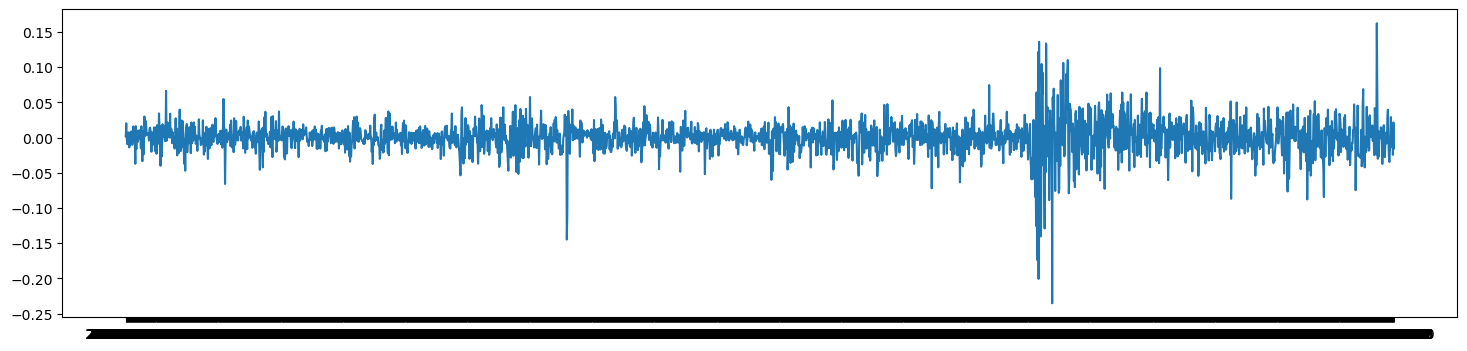

In [85]:
plt.figure(figsize=(18,4))
plt.plot(res.resid)

In [86]:
adfuller(res.resid)

(-9.517383899597752,
 3.1306086194820456e-16,
 27,
 2489,
 {'1%': -3.4329799947351503,
  '5%': -2.862701915447137,
  '10%': -2.5673885329713495},
 -11695.445376211364)

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


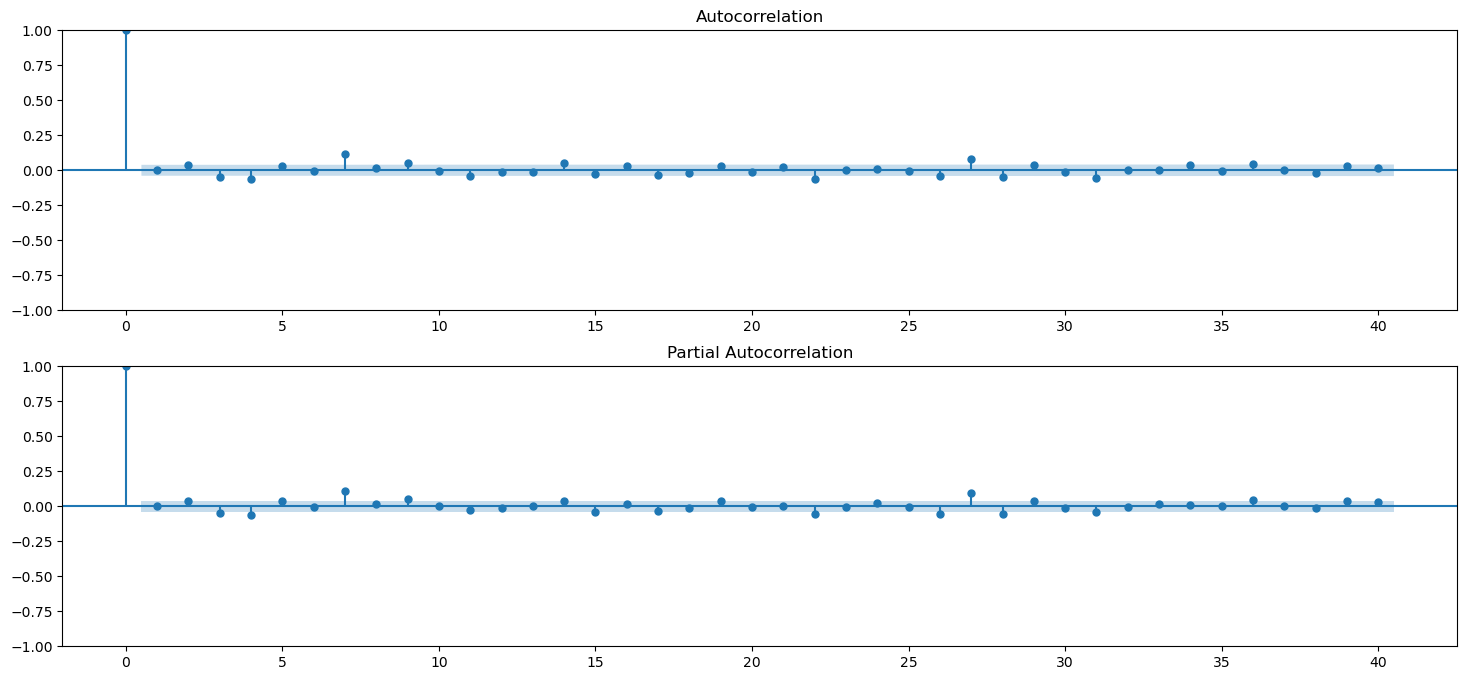

In [87]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(res.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(res.resid, lags=40, ax=ax2)

In [88]:
sm.stats.durbin_watson(res.resid.values)

1.9943577989733896

In [89]:
stats.normaltest(res.resid)

NormaltestResult(statistic=752.8839526770926, pvalue=3.260820701029263e-164)

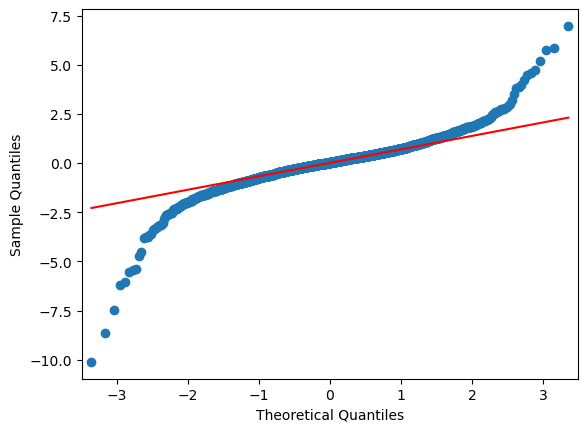

In [90]:
_ = qqplot(res.resid, line="q", fit=True)

In [91]:
r,q,p = sm.tsa.acf(res.resid, fft=True, qstat=True)

In [92]:
data = pd.DataFrame(index=np.arange(1,len(p)+1), columns=['AC', 'Q', 'pval'])
data.index.name = 'lag'
data['AC'] = r[1:]
data['Q'] = q
data['pval'] = p
data[data['pval']<0.01]

,AC,Q,pval
lag,,,
4,-0.062428,17.912415,1.283697e-03
5,0.030967,20.332829,1.082148e-03
6,-0.005708,20.415100,2.335353e-03
7,0.114306,53.419984,3.062559e-09
8,0.015645,54.038535,6.785722e-09
9,0.055530,61.833886,5.933253e-10
10,-0.005117,61.900118,1.580849e-09
11,-0.039752,65.898244,7.300609e-10
12,-0.013596,66.366089,1.522616e-09


In [93]:
preds = res.predict()

In [94]:
# mean forecast error
(dprice_train - preds).mean()

-4.011791407666972e-06

In [95]:
# mean squared error
((dprice_train - preds)**2).mean()

0.0005422159723257967

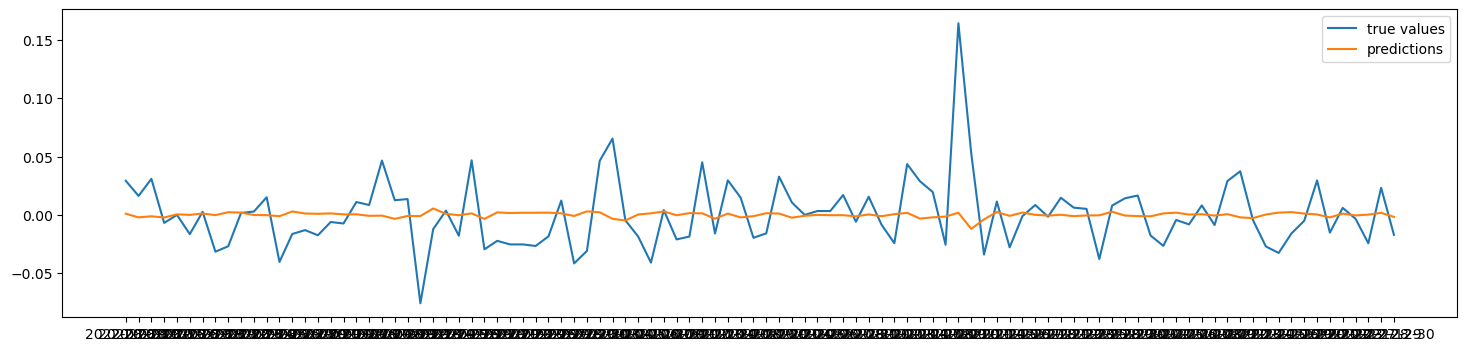

In [96]:
plt.figure(figsize=(18,4))
plt.plot(dprice_train[-100:], label='true values')
plt.plot(preds[-100:], label='predictions')
plt.legend()

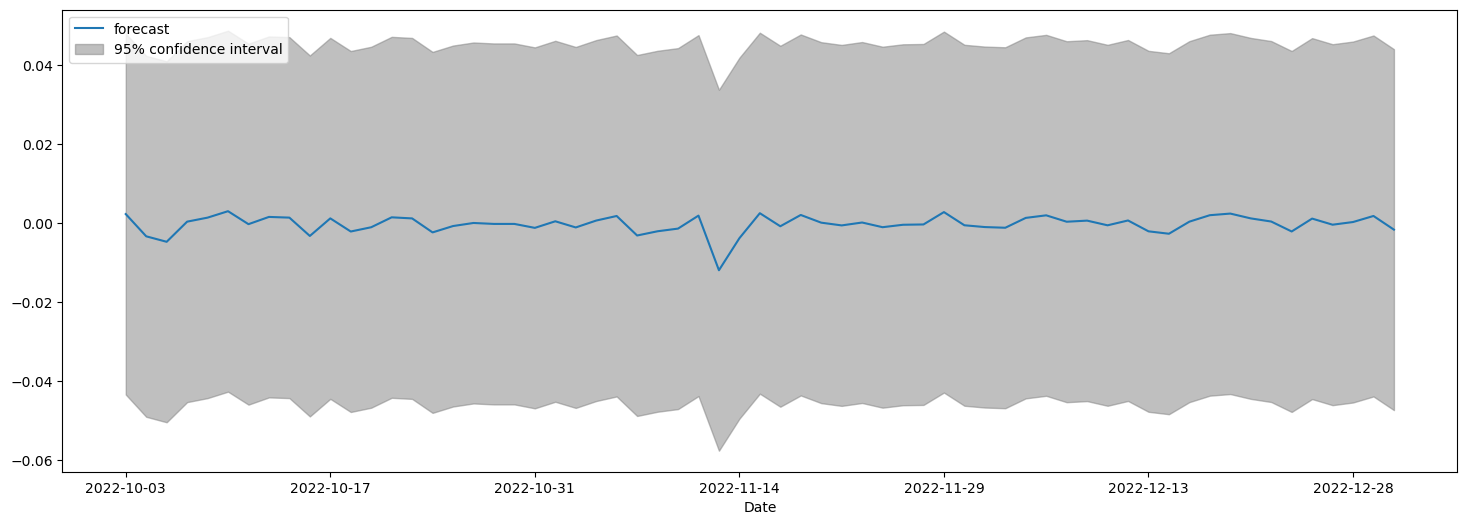

In [97]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = plot_predict(res, start='2022-10-03', end='2022-12-30', ax=ax)
legend = ax.legend(loc="upper left")

In [98]:
(np.sign(dprice_train) == np.sign(preds)).sum() / len(preds)

0.5299960270162892

In [99]:
main_mod = ARIMA(dprice_train, order=(1, 0, 0), trend='n')
main_res = main_mod.fit()

pred_df = pd.DataFrame(index=dprice_test.index, columns=['p'])

for t in tqdm(pred_df.index):
    # prepare data
    tmpdf = dprice.loc[:t].iloc[:-1]
    
    # create a model
    mod = main_mod.clone(tmpdf.values)
    with mod.fix_params(main_res.params):
        res = mod.fit()
    
    pred_df.loc[t] = res.predict(len(tmpdf)-1, len(tmpdf))[-1]

/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
100%|██████████| 90/90 [00:02<00:00, 40.19it/s]


In [100]:
pred_df['dprice'] = dprice

In [101]:
pred_df

,p,dprice
Date,,
2023-01-03,0.001243,0.012704
2023-01-04,-0.000925,0.040866
2023-01-05,-0.002974,-0.015932
2023-01-06,0.00116,0.025893
2023-01-09,-0.001885,0.005203
...,...,...
2023-05-05,0.001881,0.032508
2023-05-08,-0.002366,-0.004899
2023-05-09,0.000357,-0.006158


In [102]:
(np.sign(pred_df['p']) == np.sign(pred_df['dprice'])).sum() / len(pred_df)

0.4666666666666667

In [103]:
positions = np.sign(pred_df['p'])

In [104]:
positions

Date
2023-01-03     1
2023-01-04    -1
2023-01-05    -1
2023-01-06     1
2023-01-09    -1
              ..
2023-05-05     1
2023-05-08    -1
2023-05-09     1
2023-05-10     1
2023-05-11     1
Name: p, Length: 90, dtype: object

In [105]:
ret = positions * returns_test
cumret = (1 + ret).cumprod()

<AxesSubplot:xlabel='Date'>

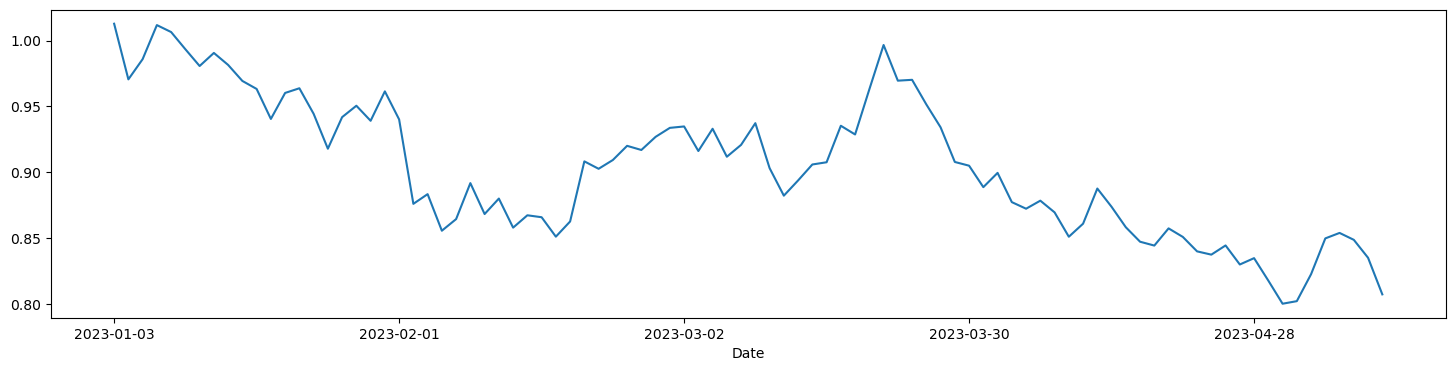

In [106]:
cumret.plot(figsize=(18,4))

<AxesSubplot:xlabel='Date'>

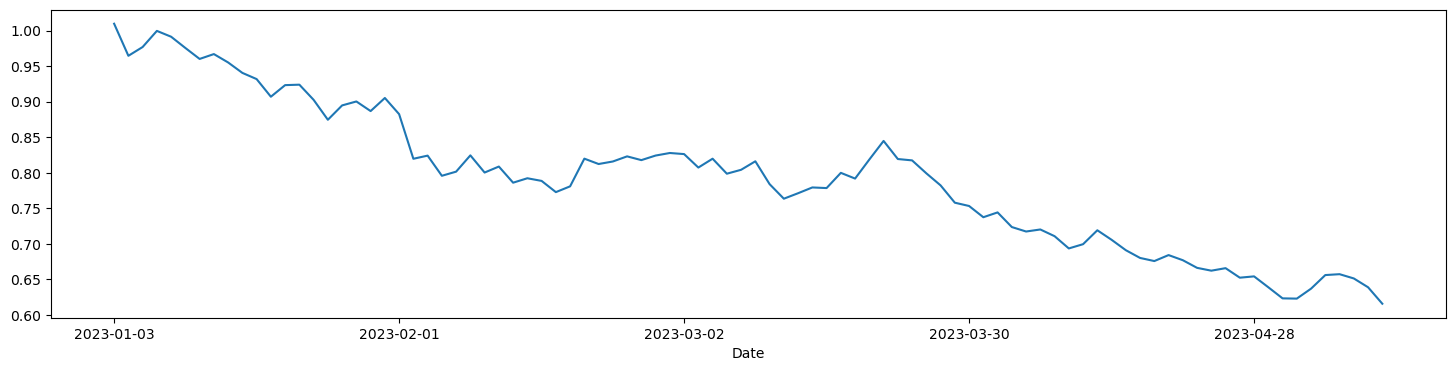

In [107]:
ret_tc = ret - 0.003
cumret_tc = (1 + ret_tc).cumprod()
cumret_tc.plot(figsize=(18,4))

In [108]:
results_df.loc['IVZ'] = calculate_metrics(cumret)
results_df.loc['IVZ with tc'] = calculate_metrics(cumret_tc)
results_df

,Total return,APR,Sharpe,MaxDD,MaxDDD
PRK,0.596359,2.704807,3.899958,-0.143101,50.0
PRK with tc,0.223433,0.758835,1.780202,-0.207575,72.0
IVZ,-0.202897,-0.470044,-1.796775,-0.209088,86.0
IVZ with tc,-0.390376,-0.749866,-4.105139,-0.384217,86.0
